## Libraries Used

In [399]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns



## Helper Functions

In [400]:
# Plot Correlation Matrix
def plot_corr_matrix(df, nr_c, targ) :
    
    corr     = df.corr()
    corr_abs = corr.abs()
    cols     = corr_abs.nlargest(nr_c, targ)[targ].index
    cm       = np.corrcoef(df[cols].values.T)

    plt.figure(figsize=(nr_c/1.5, nr_c/1.5))
    sns.set(font_scale=1.25)
    sns.heatmap(cm, linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 12}, 
                yticklabels=cols.values, xticklabels=cols.values,cmap="OrRd")
    plt.show()

# IDC9 codes to diseas 
def idc_to_group (idcnum):
    # Hearth problems
    # External injury and suppl. class - generate 4 digit number - eval to other
    idcnum = idcnum.replace('V','9999').replace('E','9999').replace('?','9999')
    idcnum = float(idcnum) 
    if   390 <= idcnum <= 459 or idcnum == 785:
        diag = 'circulatory'
    # Lung issues
    elif 460 <= idcnum <= 519 or idcnum == 786:
        diag = 'respiratory'
    # Digestive - oral, stomac, abdominal, liver
    elif 520 <= idcnum <= 579 or idcnum == 787:
        diag = 'digestive'
    # Diabetes
    elif int(idcnum) == 250:
        diag = 'diabetis'
    # Injury or poisioning
    elif 800 <= idcnum <= 999:
        diag = 'injury'
    # Musc. system or connective tissue
    elif 710 <= idcnum <= 739:
        diag = 'musculoskeletal'
    # Kidney, urinary and genitals
    elif 580 <= idcnum <= 629 or idcnum == 788:
        diag = 'genitourinary'
    # Abnormal tissue Growth
    elif 140 <= idcnum <= 239 or idcnum in [780,781,782,784,790,791,792,793,794,795,796,797,798,799]:
        diag = 'neoplasms1' 
    # Metabolic, immunity issue with no diabetes
    elif (240 <= idcnum <= 279 and idcnum != 250) or (680 <= idcnum <= 790):
        diag = 'neoplasms2'
    elif 1 <= idcnum <= 139: 
        diag = 'neoplasms3'
     # Other    
    else:
        diag = 'other'   
    return diag

# Convert age range to age average
def age_to_aveage (age):
    ages = ['[0-10)','[10-20)','[20-30)','[30-40)','[40-50)','[50-60)','[60-70)','[70-80)','[80-90)','[90-100)']
    newage = ages.index(age)*10+5
    return newage

# Dummify a categorical variable column
# df - dataframe
# var - variable/feature string
# Prefix for dummies - string
def makedummies(df,var, pre_fix = 'Class'):
    Z = pd.get_dummies(df[var], prefix = pre_fix)
    df_dummified = pd.concat((df.drop(var,1), Z), axis=1)
    return df_dummified

In [401]:
print('Reading in CSV files')
diabdata = pd.read_csv('diabetic_data.csv')
idmapping = pd.read_csv('IDs_mapping.csv')

Reading in CSV files


In [402]:
diabdata.diag_1.str.contains('V').sum()+ diabdata.diag_1.str.contains('E').sum()

1645

In [403]:
diabdata.head().transpose()

,0,1,2,3,4
encounter_id,2278392,149190,64410,500364,16680
patient_nbr,8222157,55629189,86047875,82442376,42519267
race,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian
gender,Female,Female,Female,Male,Male
age,[0-10),[10-20),[20-30),[30-40),[40-50)
weight,?,?,?,?,?
admission_type_id,6,1,1,1,1
discharge_disposition_id,25,1,1,1,1
admission_source_id,1,7,7,7,7
time_in_hospital,1,3,2,2,1


In [404]:
diabdata[(diabdata['gender']!='Male') & (diabdata['gender']!='Female')]['gender']

30506    Unknown/Invalid
75551    Unknown/Invalid
82573    Unknown/Invalid
Name: gender, dtype: object

In [421]:
# Generating the indexes for the numerical and categorical variables
categorical_idx = diabdata.dtypes[diabdata.dtypes=='object'].index
numerical_idx   = diabdata.dtypes[diabdata.dtypes!='object'].index

In [407]:
print('The unique number of patients, keep only these rows? ')
diabdata.patient_nbr.value_counts().count()

The unique number of patients, keep only these rows? 


71518

In [408]:
print('The number of unique patient ids')
diabdata.drop_duplicates(subset= ['patient_nbr'], keep = 'first')['patient_nbr'].count()

The number of unique patient ids


71518

## Feature Overview

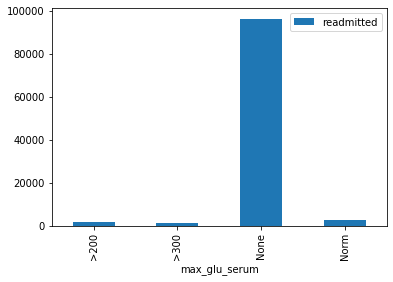

In [465]:
diabdata[['max_glu_serum','readmitted']].groupby(['max_glu_serum']).count().plot.bar()

In [467]:
diabdata['max_glu_serum'].value_counts()

None    96420
Norm     2597
>200     1485
>300     1264
Name: max_glu_serum, dtype: int64

In [409]:
os.listdir()

['healthcare.ipynb',
 '.DS_Store',
 'IDs_mapping.csv',
 'Richard EDA .ipynb',
 'diabetic_data.csv',
 'healthcare2.ipynb',
 '.ipynb_checkpoints']

In [410]:
diabdata.shape

(101766, 50)

In [411]:
idmapping.shape

(67, 2)

In [412]:
idmapping.transpose().head()

,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
admission_type_id,1,2,3,4,5,6,7,8,NaN,discharge_disposition_id,...,17,18,19,20,21,22,23,24,25,26
description,Emergency,Urgent,Elective,Newborn,Not Available,NaN,Trauma Center,Not Mapped,NaN,description,...,NaN,Transfer From Another Home Health Agency,Readmission to Same Home Health Agency,Not Mapped,Unknown/Invalid,Transfer from hospital inpt/same fac reslt in...,Born inside this hospital,Born outside this hospital,Transfer from Ambulatory Surgery Center,Transfer from Hospice


## Univariate Data analysis
- Analyzing the features induvidually

In [413]:
print('The target Variable Classes')
diabdata.readmitted.value_counts()

The target Variable Classes


NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

In [415]:
diabdata.diabetesMed.value_counts()

Yes    78363
No     23403
Name: diabetesMed, dtype: int64

In [466]:
# Value distribution of categorical Variables

# for col in diabdata.columns.tolist():
#     print(diabdata[col].value_counts())

In [16]:
print('Numerous categorical features')
# diabdata.dtypes

Numerous categorical features


In [ ]:
diabdata.discharge

In [418]:
print('The different types of data in the dataset: \n',diabdata.dtypes.value_counts())


The different types of data in the dataset: 
 object    37
int64     13
dtype: int64


## Data Cleaning
- Missing Values
- Outliers


In [281]:
print('Missing Values per feature')
print('Top 10 variables of missing values')
diabdata.isnull().sum().sort_values(ascending=False)[:10]

Missing Values per feature
Top 10 variables of missing values


newage              0
num_procedures      0
metformin           0
A1Cresult           0
max_glu_serum       0
number_diagnoses    0
diag_3              0
diag_2              0
diag_1              0
number_inpatient    0
dtype: int64

In [18]:
np.sum(diabdata.age.isnull())

0

In [424]:
diabdata[diabdata['gender']=='Unknown/Invalid']['gender']

30506    Unknown/Invalid
75551    Unknown/Invalid
82573    Unknown/Invalid
Name: gender, dtype: object

In [426]:
# Getting rid of the Unknowns for Gender - not real significance
diabdata.gender = diabdata.gender.replace('Unknown/Invalid','Female')
diabdata.gender.value_counts()

Female    54711
Male      47055
Name: gender, dtype: int64

Text(0.5, 1.0, 'Age of Patient VS. Readmission')

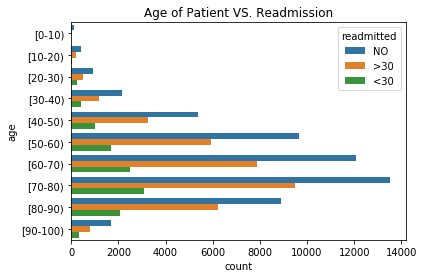

In [423]:
sns.countplot(y= diabdata['age'], hue = diabdata['readmitted']).set_title('Age of Patient VS. Readmission')

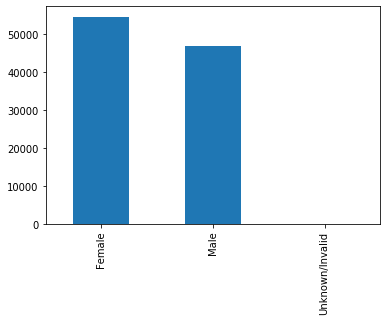

In [362]:
diabdata.gender.value_counts().plot.bar()

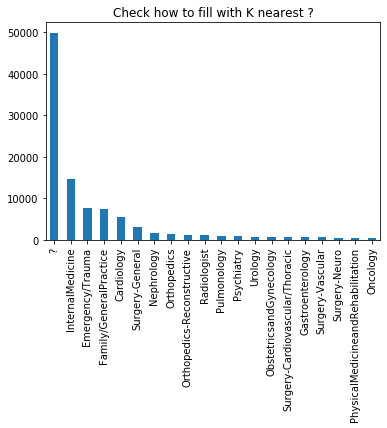

In [374]:

diabdata.medical_specialty.value_counts()[:20].plot.bar(title='Check how to fill with K nearest ?')

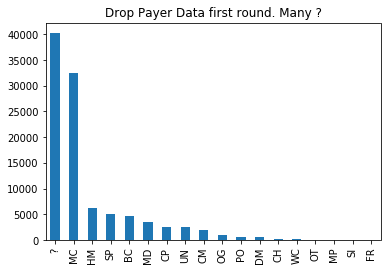

In [377]:
diabdata.payer_code.value_counts().plot.bar(title ='Drop Payer Code first round. Many ?')

In [353]:
diabdata.diag_1.value_counts()[:10]

428    6862
414    6581
786    4016
410    3614
486    3508
427    2766
491    2275
715    2151
682    2042
434    2028
Name: diag_1, dtype: int64

In [446]:
# diabdata.diag_2.value_counts()[:20]

In [447]:
# diabdata.diag_3.value_counts()


In [352]:
# diabdata.groupby('diag_1').count().sort_values('readmitted',ascending=False)[:30]

In [74]:
diagnosis = diabdata.loc[diabdata['readmitted']=='<30',['readmitted','diag_1','diag_2','diag_3']]
# percent_miss_count = (dftrain.isnull().sum()/dftrain.isnull().count()).sort_values(ascending=False)
#['diag_1','diag_2','diag_3']
# pd.concat([tot_miss_count,percent_miss_count], axis =1,keys=['NA_count','NA_percent'])[:20]

print
diagnosis.groupby('diag_1').count().sort_values('readmitted',ascending=False)[:30]['readmitted'].sum()


6952

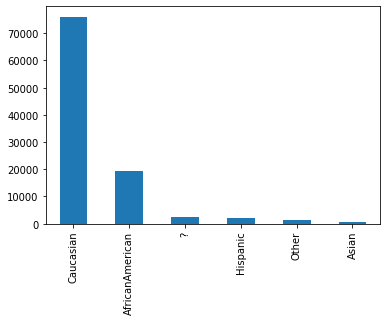

In [443]:
diabdata.race.value_counts().plot.bar()

In [444]:
# Take care of the race missing values and minority asian as outlier
diabdata.race = diabdata.race.replace('?','Missing').replace('Asian','Other')

In [445]:
# Following guideline filling in missing for '?'
diabdata.medical_specialty  = diabdata.medical_specialty.replace('?','Missing')

## Feature Engineering
- Grouping values within feature: IDC code (based on first 3 characters)
- One hot encoding
- Dummification

In [ ]:
# Converting IDC9 iagnostic codes  to characters

diags = ['diag_1','diag_2','diag_3']
for diag in diags:
    diagt = str(diag + '_temp')
    diabdata[diagt] = diabdata[diag].apply(lambda x : idc_to_group(x))

Text(0.5, 1.0, 'Primary Diagnosis')

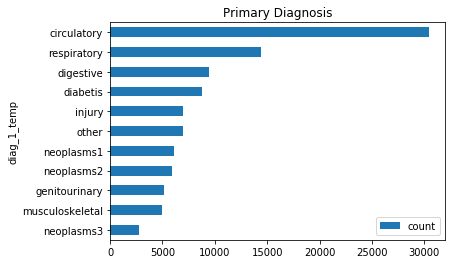

In [386]:
diabdata.groupby('diag_1_temp').agg({'diag_1':['count']})['diag_1'].sort_values('count').plot.barh() 
#,ascending=False
plt.title('Primary Diagnosis')

Text(0.5, 1.0, 'Secondary Diagnosis')

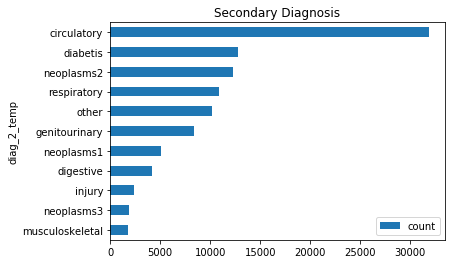

In [385]:
diabdata.groupby('diag_2_temp').agg({'diag_2':['count']})['diag_2'].sort_values('count').plot.barh()
plt.title('Secondary Diagnosis')

Text(0.5, 1.0, 'Third Diagnosis')

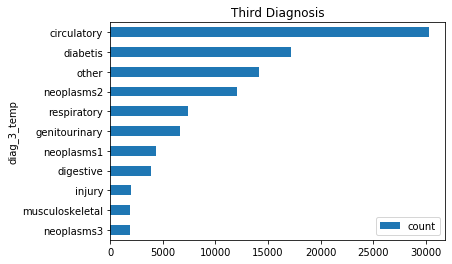

In [387]:
diabdata.groupby('diag_3_temp').agg({'diag_3':['count']})['diag_3'].sort_values('count').plot.barh()
plt.title('Third Diagnosis')

In [394]:
diabdata.diag_1.str.contains('V').sum()+ diabdata.diag_1.str.contains('E').sum()

1645

In [432]:
# Transform the target variable to those admitted before 30 days and others
diabdata.readmitted = diabdata.readmitted.apply(lambda x : 1 if x =='<30' else 0)

In [ ]:
# Convert age range to ages
diabdata['newage'] = diabdata['age'].apply(lambda x: age_to_aveage(x) )
diabdata.newage.value_counts()

In [436]:
# Drop columns that are not needed

# cols_to_drop = ['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
#        'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
#        'time_in_hospital', 'payer_code', 'medical_specialty',
#        'num_lab_procedures', 'num_procedures', 'num_medications',
#        'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
#        'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
#        'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
#        'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
#        'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
#        'tolazamide', 'examide', 'citoglipton', 'insulin',
#        'glyburide-metformin', 'glipizide-metformin',
#        'glimepiride-pioglitazone', 'metformin-rosiglitazone',
#        'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
#        'newage']

cols_to_drop = ['age','weight','patient_nbr','encounter_id','payer_code','max_glu_serum']

df.drop(cols_to_drop, inplace= False, axis = 1)



In [ ]:
# Dummify primary diagnosis
makedummies(diabdata,'diag_1_temp', pre_fix = 'class')

In [ ]:
# Dummify gender
makedummies(diabdata,'gender', pre_fix = 'class')

In [ ]:
# Dummify Race
makedummies(diabdata,'race', pre_fix = 'class')

## Standardize Data 


In [ ]:
# Create the standardized version of the datasets

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(diabdata.drop('readmitted',1))
diabdata_scaled = scaler.transform(diabdata.drop('readmitted',1))
# dftrain_y_scaled = scaler.transform(dftrain['SalePrice']) # not needed?


## Create Train and Test data

In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

## Cross Validation and Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn                 import datasets
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, train_test_split






## Fit Model

it allows the Ridge or Lasso penality with the hyperparameter  𝛼
α
  (we call it  𝜆
λ
  in the class), default =  1𝑒−4
1
e
−
4
 .
We choose either Ridge or Lasso by assigning the penalty = 'Ridge', penality = 'Lasso', with default = 'Ridge'
It has a parameter controlling the maximal iterations called max_iter, default to  100
100
 .
a parameter called solver, which accepts the solver option 'liblinear' of LogisticRegression. But when the solver is set to be sgd, it switches to a Stochastic Gradient Descent logistic classifier.
It has two standard model attributes coef_, intercept_.
it has the standard APIs of
fit(X, Y)
predict(X)
predict_proba(X)
score(X, Y)
set_params()
get_params()

In [ ]:
from sklearn.linear_model    import LogisticRegression, SGDClassifier
# from sklearn.tree            import DecisionTreeClassifier
# from sklearn.ensemble        import RandomForestRegressor

print('Using Logistic Regression')
logit = LogisticRegression(C=1/self.alpha,penalty='l1',max_iter=100,solver='liblinear')


grid_logit = GridSearchCV(logit, parameters, cv = 5, verbose=1 , scoring = 'Accuracy')


grid_logit.fit(diabdata.drop('readmitted',1), diabdata.readmitted)
print('Gridsearch Object Best Score: ',grid_logit.best_score_)